# Function superresolution

In this task we will use simulated data for super-resolution, where we want to learn how to reconstruct high-resolution signals from low-resolution observations.

In [109]:
# Import necessary libaries
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## Generating the simulated signals from a Fourier series

In [57]:
# Data is sampled from a truncated Fourier series
def generateData(x, downscale_factor=5, no_samples=1000, no_waves=5):
    """
    x: The input grid (e.g., a 1D array of x-values) where the signals are evaluated.
    no_waves: The maximum number of sine waves to combine to create each signal.
    """
    uall = []  # high-resolution signals
    uall_lr = []  # low-resolution signals

    for j in range(no_samples):
        waves = np.random.randint(1, no_waves)
        u = 1 / (2 * np.pi)  # signal initialization
        for i in range(waves):
            amplitude = np.random.randn()  # randomly pick get an amplitude
            u += amplitude * np.sin(
                np.pi * (i + 1) * x
            )  # fourier series (with sine only)
        u = u / np.max(u)  # signal

        uall.append(u)
        uall_lr.append(u[::downscale_factor])

    return [np.array(uall_lr), np.array(uall)]

In [58]:
# Generate some training data
no_points = 101
downscale_factor = 4
no_samples = 100

# High res grid
x = np.linspace(-np.pi, np.pi, no_points)

# Low res grid
x_lr = x[::downscale_factor]

# Generated high/low res solutions
[u_lr, u] = generateData(x, downscale_factor, no_samples)  # u_lr - X_train, u - y_train

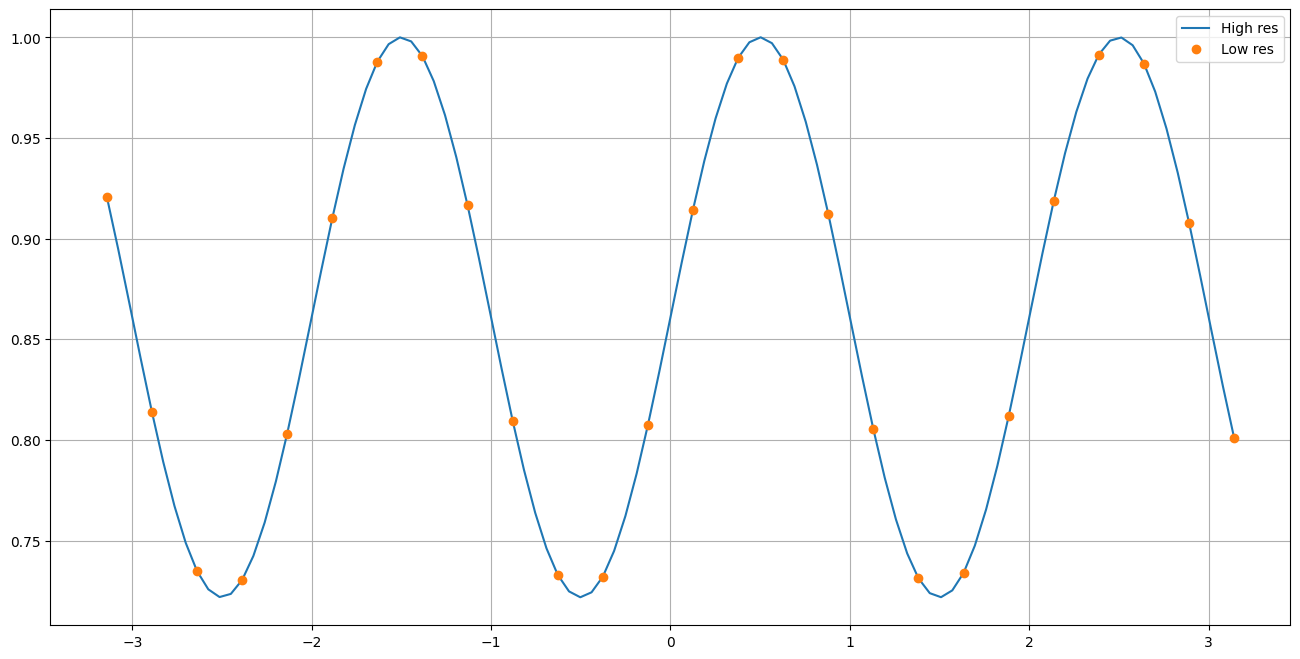

In [59]:
# Visualize some training samples
ix = np.random.randint(u.shape[0])

plt.figure(figsize=(16, 8))
plt.plot(x, u[ix,])
plt.plot(x_lr, u_lr[ix,], "o")
plt.grid()
plt.legend(["High res", "Low res"])
plt.show()

## Model Building and Training

In [60]:
# Import neccessary ml libraries
import tensorflow as tf

Here we are saying that our `X_train` is `u_lr `(signal of low resolution) and our `y_train` is `u` ( the signal with all generated points). with coarsening or downscaling factor of 4, the `input_shape = 26` and `output_shape = 100`.

In [133]:
u_lr.shape

(100, 26)

In [62]:
u.shape

(100, 101)

In [63]:
inp = tf.keras.layers.Input(shape=(26,))
b = tf.keras.layers.Dense(128, activation="relu")(inp)
b = tf.keras.layers.Dense(128, activation="relu")(b)
# x = tf.keras.layers.Dense(32, activation='relu')(b)
out = tf.keras.layers.Dense(101, activation="linear")(b)

model = tf.keras.Model(inp, out)

model.compile(optimizer="adam", loss="mse", metrics=["mse"])

history = model.fit(u_lr, u, batch_size=1, epochs=500, verbose=0, validation_split=0.2)

## Model Evaluation

In [64]:
import pandas as pd

hist = pd.DataFrame(history.history)
hist.tail()

,loss,mse,val_loss,val_mse
495,0.000332,0.000332,0.001801,0.001801
496,0.000586,0.000586,0.001595,0.001595
497,0.000507,0.000507,0.001323,0.001323
498,0.000274,0.000274,0.001552,0.001552
499,0.000268,0.000268,0.001601,0.001601


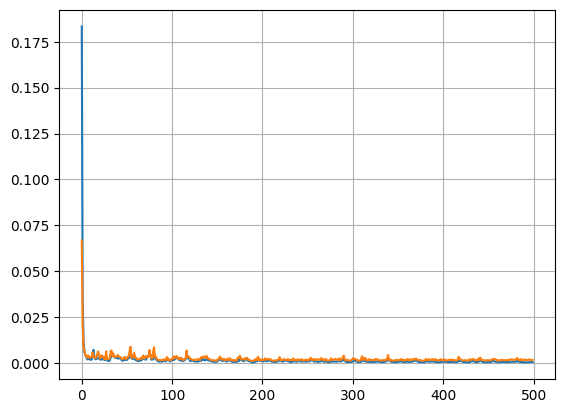

In [65]:
plt.plot(hist.mse)
plt.plot(hist.val_mse)
plt.grid()
plt.show()

## Model Predictions

#### Generate test dataset

In [117]:
# x = np.linspace(-np.pi, np.pi, no_points)
[test_lr, test_hr] = generateData(x, downscale_factor=4, no_samples=10)

pred = model.predict(test_lr)

1/1 [==============================] - 0s 14ms/step


In [131]:
mses = []

for ix in range(len(test_lr)):
    mse_nn = mean_squared_error(test_hr[ix], pred[ix])
    mses.append(mse_nn)  # append to the list
    
print("Average MSE after NN interpolation: ", np.mean(mses))

Average MSE after NN interpolation:  0.000674419783811415


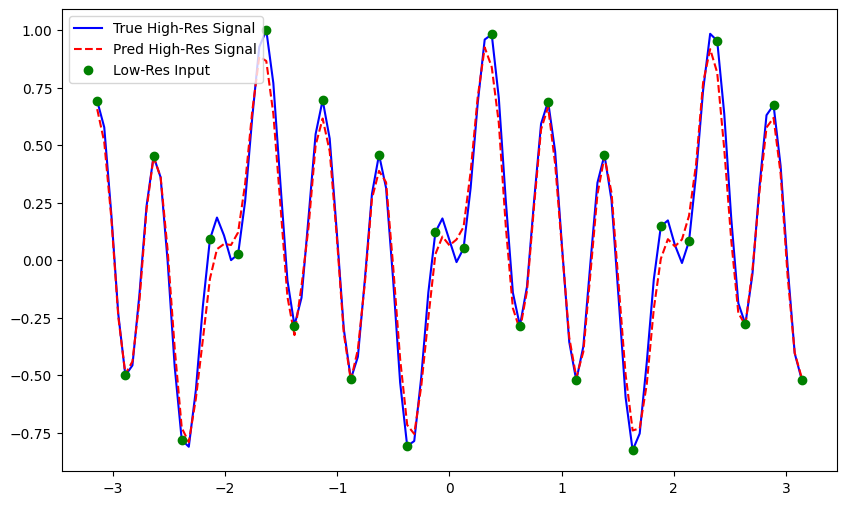

In [67]:
sample_index = np.random.randint(pred.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(x, test_hr[sample_index], label="True High-Res Signal", color="blue")
plt.plot(
    x, pred[sample_index], label="Pred High-Res Signal", linestyle="--", color="red"
)
plt.plot(x_lr, test_lr[sample_index], "o", label="Low-Res Input", color="green")
plt.legend()
plt.show()

## SciPy Benchmarking

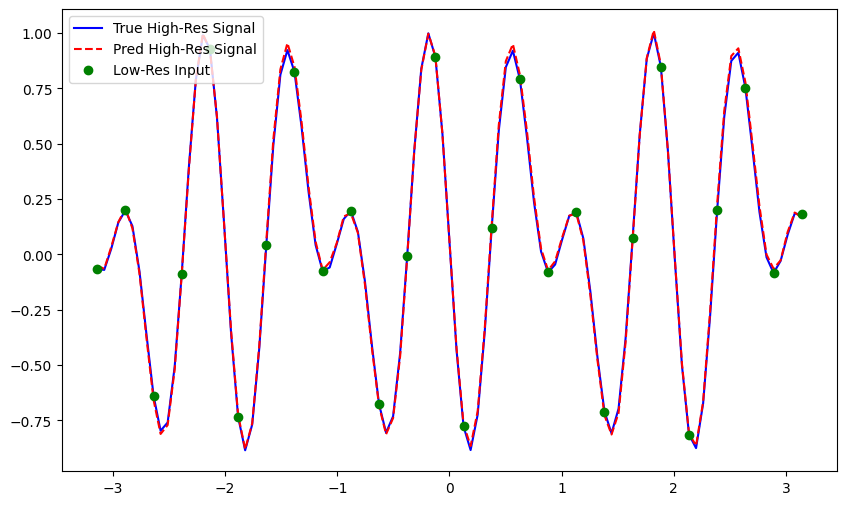

In [88]:
# sample_index = np.random.randint(pred.shape[0])
sample_index = 0

plt.figure(figsize=(10, 6))
plt.plot(x, test_hr[sample_index], label="True High-Res Signal", color="blue")
plt.plot(
    x, pred[sample_index], label="Pred High-Res Signal", linestyle="--", color="red"
)
plt.plot(x_lr, test_lr[sample_index], "o", label="Low-Res Input", color="green")
plt.legend()
plt.show()

### Learning scipy.interpolate

#### Linear interpolation: `interp1d`

a:  [0 1 2 3 4 5 6 7 8 9]
b:  [1.         0.71653131 0.51341712 0.36787944 0.26359714 0.1888756
 0.13533528 0.09697197 0.06948345 0.04978707]


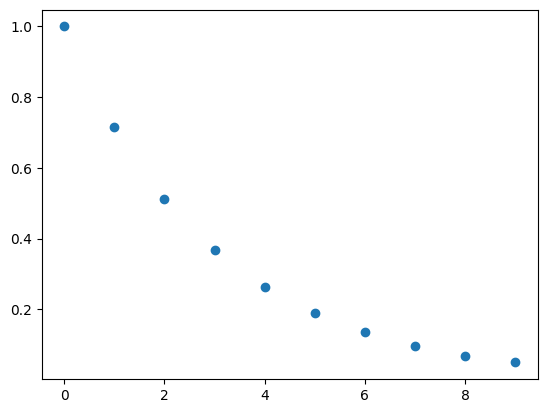

In [70]:
# low resolution
a = np.arange(0, 10)
print("a: ", a)
b = np.exp(-a / 3)
print("b: ", b)
f = interp1d(a, b)  # interpolation function

plt.plot(a, b, "o")
plt.show()

We are using the low resolution data to get a high resolution "data"/signal. Interpolation is a way to estimate missing values between two known values.

a_new:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1
 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3 8.4 8.5 8.6 8.7 8.8 8.9]
b_new:  [1.         0.97165313 0.94330626 0.91495939 0.88661252 0.85826566
 0.82991879 0.80157192 0.77322505 0.74487818 0.71653131 0.69621989
 0.67590847 0.65559705 0.63528563 0.61497421 0.5946628  0.57435138
 0.55403996 0.53372854 0.51341712 0.49886335 0.48430958 0.46975582
 0.45520205 0.44064828 0.42609451 0.41154074 0.39698698 0.38243321
 0.36787944 0.35745121 0.34702298 0.33659475 0.32616652 0.31573829
 0.30531006 0.29488183 0.2844536  0.27402537 0.26359714 0.25612498
 0.24865283 0.24118068 0.23370852 0.22623637 0.21876422 0.21129206
 0.20381991 0.19634776 0.1888756  0.18352157 0.17816754 0.17281351
 0.16745947 0.1

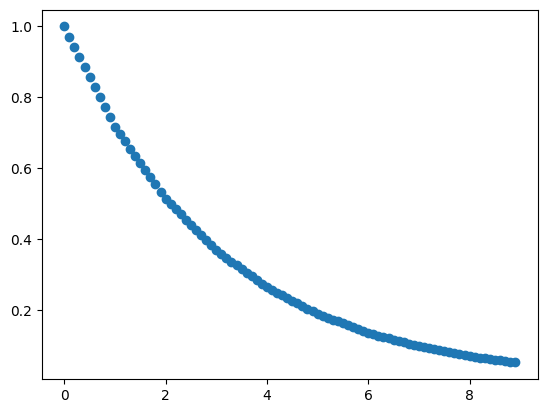

In [71]:
# high resolution
a_new = np.arange(0, 9, 0.1)
print("a_new: ", a_new)
b_new = f(a_new)
print("b_new: ", b_new)

plt.plot(a_new, b_new, "o")
plt.show()

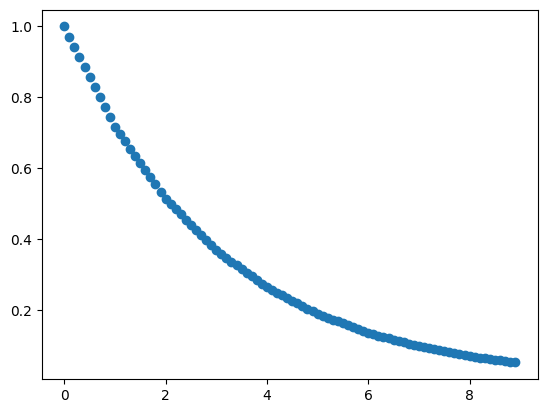

In [72]:
plt.plot(a_new, b_new, "o")
plt.show()

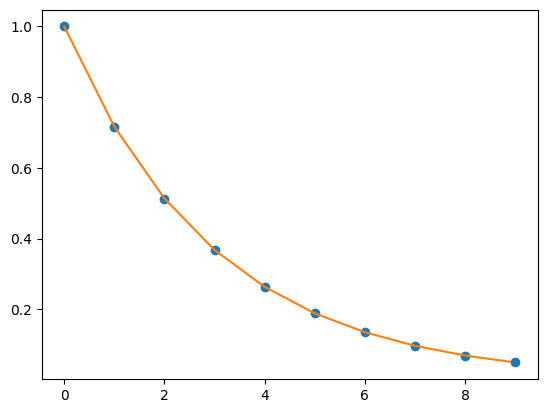

In [73]:
plt.plot(a, b, "o", a_new, b_new, "-")
plt.show()

##### Let's try to do same for only one signal we generated from the Fourier series

Here, we will start small. Beginning with just interpolating a single sample signal from the u_lr.

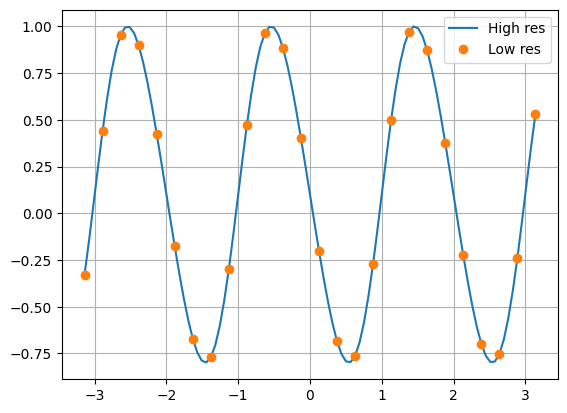

In [89]:
# Original signal
ix = np.random.randint(u.shape[0])

# plt.figure(figsize=(16, 8))
plt.plot(x, u[ix,])
plt.plot(x_lr, u_lr[ix,], "o")
plt.grid()
plt.legend(["High res", "Low res"])
plt.show()

x_lr:  [-3.14159265 -2.89026524 -2.63893783 -2.38761042 -2.136283   -1.88495559
 -1.63362818 -1.38230077 -1.13097336 -0.87964594 -0.62831853 -0.37699112
 -0.12566371  0.12566371  0.37699112  0.62831853  0.87964594  1.13097336
  1.38230077  1.63362818  1.88495559  2.136283    2.38761042  2.63893783
  2.89026524  3.14159265]
u_lr:  [-0.32917089  0.44002586  0.95488487  0.89980027  0.42664207 -0.17564767
 -0.67012277 -0.77118817 -0.29950096  0.47083326  0.96438451  0.88612581
  0.40203863 -0.2004462  -0.68453338 -0.76279207 -0.26924083  0.5010934
  0.9727806   0.8717152   0.3772401  -0.22504964 -0.69820783 -0.75329243
 -0.23843343  0.53076333]


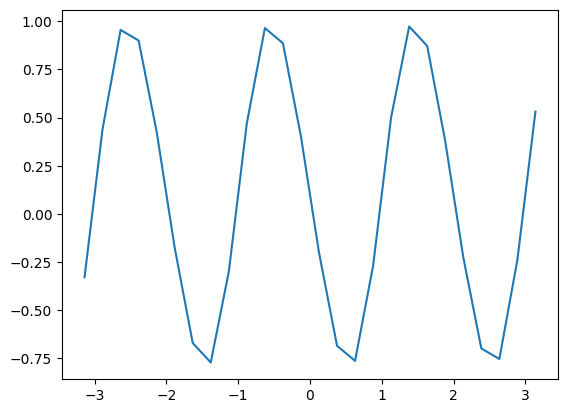

In [90]:
# Show the low resolution signal first
print("x_lr: ", x_lr)
print("u_lr: ", u_lr[ix])

plt.plot(x_lr, u_lr[ix])
plt.show()

x-high-res: 
 [-3.14159265e+00 -3.07876080e+00 -3.01592895e+00 -2.95309709e+00
 -2.89026524e+00 -2.82743339e+00 -2.76460154e+00 -2.70176968e+00
 -2.63893783e+00 -2.57610598e+00 -2.51327412e+00 -2.45044227e+00
 -2.38761042e+00 -2.32477856e+00 -2.26194671e+00 -2.19911486e+00
 -2.13628300e+00 -2.07345115e+00 -2.01061930e+00 -1.94778745e+00
 -1.88495559e+00 -1.82212374e+00 -1.75929189e+00 -1.69646003e+00
 -1.63362818e+00 -1.57079633e+00 -1.50796447e+00 -1.44513262e+00
 -1.38230077e+00 -1.31946891e+00 -1.25663706e+00 -1.19380521e+00
 -1.13097336e+00 -1.06814150e+00 -1.00530965e+00 -9.42477796e-01
 -8.79645943e-01 -8.16814090e-01 -7.53982237e-01 -6.91150384e-01
 -6.28318531e-01 -5.65486678e-01 -5.02654825e-01 -4.39822972e-01
 -3.76991118e-01 -3.14159265e-01 -2.51327412e-01 -1.88495559e-01
 -1.25663706e-01 -6.28318531e-02  4.44089210e-16  6.28318531e-02
  1.25663706e-01  1.88495559e-01  2.51327412e-01  3.14159265e-01
  3.76991118e-01  4.39822972e-01  5.02654825e-01  5.65486678e-01
  6.2831853

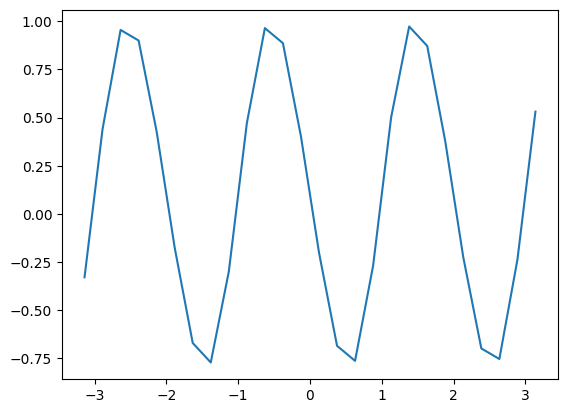

In [91]:
g = interp1d(x_lr, u_lr[ix])

# From this generate your interpolation using scipy.interpolate
u_new = g(x)

# Show the low resolution signal first
print("x-high-res: \n", x)  # from the np.pi generated from cells above
print("u-high-res-interpolated: \n", u_new)

plt.plot(x, u_new)
plt.show()

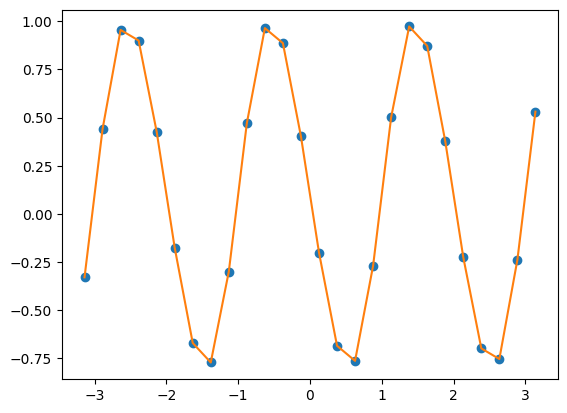

In [92]:
plt.plot(x_lr, u_lr[ix], "o", x, u_new, "-")
plt.show()

In [110]:
# MSE of above signal
mse_cub = mean_squared_error(u[ix], u_new)
print("MSE of signal: ", mse_cub)

MSE of signal:  0.0012630576353651855


#### Cubic interpolation

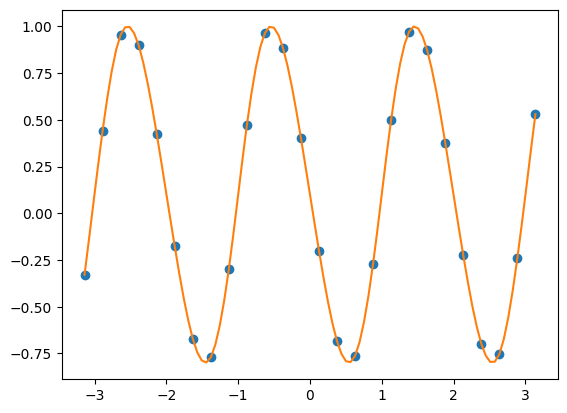

In [97]:
spl = interp1d(x_lr, u_lr[ix], kind="cubic")

u_cub = spl(x)  # generate interpolated signals from function

plt.plot(x_lr, u_lr[ix], "o", x, u_cub, "-")
plt.show()

So far, i have a good understanding of how to interpolate with `interp1d` for single signals. Now, how do we do this for say, 10 different functions? and how do we calculate the MSE after interpolation?

In [99]:
# MSE of above signal
mse_cub = mean_squared_error(u[ix], u_cub)
print("MSE of signal: ", mse_cub)

MSE of signal:  6.021985556775523e-06


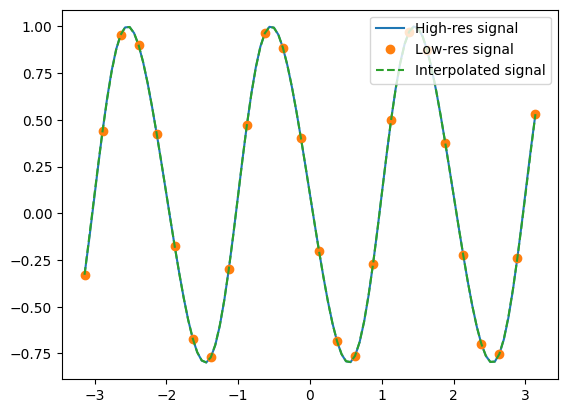

In [108]:
plt.plot(x, u[ix], "-", label="High-res signal")  # High-res signal
plt.plot(x_lr, u_lr[ix], "o", label="Low-res signal")  # Low-res signal
plt.plot(x, u_cub, "--", label="Interpolated signal")  # Interpolated signal
plt.legend(loc=1)
plt.show()

### Interpolation for multiple signals

#### For linear interpolation

In [129]:
mses = []

for ix in range(len(test_lr)):
    g = interp1d(x_lr, test_lr[ix])
    u_lin = g(x)  # generate interpolated signals from function

    # Calculate MSE
    mse_lin = mean_squared_error(test_hr[ix], u_lin)
    mses.append(mse_lin)  # append to the list

print("Average MSE after linear interpolation: ", np.mean(mses))

Average MSE after linear interpolation:  0.017808938257508816


#### For cubic interpolation

In [128]:
mses = []

for ix in range(len(test_lr)):
    spl = interp1d(x_lr, test_lr[ix], kind="cubic")
    u_cub = spl(x)  # generate interpolated signals from function

    # Calculate MSE
    mse_cub = mean_squared_error(test_hr[ix], u_cub)
    mses.append(mse_cub)  # append to the list

print("Average MSE after cubic interpolation: ", np.mean(mses))

Average MSE after cubic interpolation:  0.007474206249537369
